In [1]:
import sys

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

import cv2
from PIL import Image
from torchvision import transforms
from pipelines.video_action_recognition_config import get_cfg_defaults
from models.tuber_ava import build_model
from glob import glob
import json
import datasets.video_transforms as T
import random

def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id:" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None
            items[81] = "happens"

    return items

items = read_label_map("../assets/ava_action_list_v2.1.pbtxt")

def make_transforms(image_set, cfg):
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    print("transform image crop: {}".format(cfg.CONFIG.DATA.IMG_SIZE))
    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSizeCrop_Custom(cfg.CONFIG.DATA.IMG_SIZE),
            T.ColorJitter(),
            normalize,
        ])

    if image_set == 'val':
        return T.Compose([
            T.Resize_Custom(cfg.CONFIG.DATA.IMG_SIZE),
            normalize,
        ])

    if image_set == 'visual':
        return T.Compose([
            T.Resize_Custom(cfg.CONFIG.DATA.IMG_SIZE),
            normalize,
        ])
    raise ValueError(f'unknown {image_set}')

cfg = get_cfg_defaults()
cfg.merge_from_file("./configuration/TubeR_CSN152_AVA21.yaml")
model, _, _ = build_model(cfg)

checkpoint = torch.load("../pretrained_models/main/TubeR_CSN152_AVA21.pth")
model_dict = model.state_dict()
pretrained_dict = {k[7:]: v for k, v in checkpoint['model'].items() if k[7:] in model_dict}
unused_dict = {k[:7]: v for k, v in checkpoint['model'].items() if not k[7:] in model_dict}
not_found_dict = {k: v for k, v in model_dict.items() if not "module."+k in checkpoint['model']}
print("# successfully loaded model layers:", len(pretrained_dict.keys()))
print("# unused model layers:", len(unused_dict.keys()))
print("# not found layers:", len(not_found_dict.keys()))
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
transforms=make_transforms("val", cfg)

model.eval()
sample_image1_path = "/mnt/tmp/frames/xeGWXqSvC-8/xeGWXqSvC-8_000360.jpg" #False
sample_image2_path = "/mnt/tmp/frames/CMCPhm2L400/CMCPhm2L400_011200.jpg" #False
sample_image3_path = "/mnt/tmp/frames/Gvp-cj3bmIY/Gvp-cj3bmIY_024750.jpg" #True

# '/home/nsml/assets/ava_{}_v21.json'
val_bbox_json = json.load(open(cfg.CONFIG.DATA.ANNO_PATH.format("val")))
video_frame_bbox = val_bbox_json["video_frame_bbox"]

def sim_matrix(a, b, eps=1e-8):
    """
    a: hs x bs x dim
    b: nq x bs x dim
    output: bs x hs x nq
    """
    a, b = a.permute(1,0,2), b.permute(1,0,2)
    a_n, b_n = a.norm(dim=2)[:, :, None], b.norm(dim=2)[:, :, None]
    a_norm = a / torch.clamp(a_n, min=eps)
    b_norm = b / torch.clamp(b_n, min=eps)
    sim_mt = torch.bmm(a_norm, b_norm.transpose(1, 2))
    return sim_mt

def load_annotation(sample_id, video_frame_list): # (val 혹은 train의 key frame을 표시해놓은 list)

    num_classes = 80
    boxes, classes = [], []
    target = {}

    first_img = cv2.imread(video_frame_list[0])

    oh = first_img.shape[0]
    ow = first_img.shape[1]
    if oh <= ow:
        nh = 256
        nw = 256 * (ow / oh)
    else:
        nw = 256
        nh = 256 * (oh / ow)

    p_t = int(32 // 2)
    key_pos = p_t

    anno_entity = video_frame_bbox[sample_id]

    for i, bbox in enumerate(anno_entity["bboxes"]):
        label_tmp = np.zeros((num_classes, ))
        acts_p = anno_entity["acts"][i]
        for l in acts_p:
            label_tmp[l] = 1

        if np.sum(label_tmp) == 0: continue
        p_x = np.int_(bbox[0] * nw)
        p_y = np.int_(bbox[1] * nh)
        p_w = np.int_(bbox[2] * nw)
        p_h = np.int_(bbox[3] * nh)

        boxes.append([p_t, p_x, p_y, p_w, p_h])
        classes.append(label_tmp)

    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 5)
    boxes[:, 1::3].clamp_(min=0, max=int(nw))
    boxes[:, 2::3].clamp_(min=0, max=nh)

    if boxes.shape[0]:
        raw_boxes = F.pad(boxes, (1, 0, 0, 0), value=0)
    else:
        raw_boxes = boxes
    classes = np.array(classes)
    classes = torch.as_tensor(classes, dtype=torch.float32).reshape(-1, num_classes)

    target["image_id"] = [str(sample_id).replace(",", "_"), key_pos]
    target['boxes'] = boxes
    target['raw_boxes'] = raw_boxes
    target["labels"] = classes
    target["orig_size"] = torch.as_tensor([int(nh), int(nw)])
    target["size"] = torch.as_tensor([int(nh), int(nw)])
    # self.index_cnt = self.index_cnt + 1

    return target

def loadvideo(start_img, vid, frame_key):
    frame_path = "/mnt/tmp/frames/{}"
    video_frame_path = frame_path.format(vid)
    video_frame_list = sorted(glob(video_frame_path + '/*.jpg'))

    if len(video_frame_list) == 0:
        print("path doesnt exist", video_frame_path)
        return [], []
    
    target = load_annotation(frame_key, video_frame_list)

    start_img = np.max(start_img, 0)
    end_img = start_img + 32 * 2
    indx_img = list(np.clip(range(start_img, end_img, 2), 0, len(video_frame_list) - 1))
    buffer = []
    for frame_idx in indx_img:
        tmp = Image.open(video_frame_list[frame_idx])
        tmp = tmp.resize((target['orig_size'][1], target['orig_size'][0]))
        buffer.append(tmp)

    return buffer, target


# TubeR's csn152, ava21 results
gpu_num = random.randint(0,3)
detection = '/mnt/video-nfs5/users/jinsung/results/tubelet-transformer/eval/tmp3/{}.txt'.format(gpu_num) #numbers are changeable
gt = '/mnt/video-nfs5/users/jinsung/results/tubelet-transformer/eval/tmp3/GT_{}.txt'.format(gpu_num)

# what label am I interested in?
label = 55 # "stand", for example

# find a video key frame with desired label

key_frame_candidates = []
with open(gt) as f:
    for line in f.readlines():
        img_id = line.split(' ')[0]
        annotation = [int(float(n)) for n in line.split('[')[1].split(']')[0].split(',')]
        multi_hot_obj_label = annotation[6:]
        if multi_hot_obj_label[label-1] == 1:
            key_frame_candidates.append(img_id)

# pick one of key_frame_candidates:
if len(key_frame_candidates) == 0:
    print("no key frame found with following label: {}".format(items[label]), " try another gpu_num")

ind = random.randint(0, len(key_frame_candidates)-1)
key_frame = key_frame_candidates[ind]
frame_second = key_frame.split("_")[-1]
vid = "_".join(key_frame.split('_')[:-1])
"""
# frame_key is one of "xeGWXqSvC-8,0911", "CMCPhm2L400,1274", "Gvp-cj3bmIY,1725", "Gvp-cj3bmIY_1675"
frame_key = "Gvp-cj3bmIY,1675" 
vid, frame_second = frame_key.split(',')
"""
frame_key = ",".join([vid, frame_second])
timef = int(frame_second) - 900
start_img = np.max((timef * 30 - 32 // 2 * 2, 0))

imgs, target = loadvideo(start_img, vid, frame_key)

"""
start_img: start_img number, int
vid: xeGWXqSvC-8, CMCPhm2L400, Gcp-cj3bmIY
frame_key: 0911, 1274, 1725

"""
orig_vid = imgs
imgs, target = transforms(imgs, target)
ho,wo = imgs[0].shape[-2], imgs[0].shape[-1]
imgs = torch.stack(imgs, dim=0)
imgs = imgs.permute(1, 0, 2, 3)

# print(len(imgs), imgs[0].shape, target)

device = "cuda:0"
model = model.to(device)
imgs = imgs.to(device)

# print(attn_weights.shape)

conv_features, enc_attn_weights, dec_attn_weights = [], [], []
enc_features = []
query_features = []
cls_enc_attn_weights, cls_dec_attn_weights = [], []
cls_enc_features = []
cls_query_features = []
input = imgs.unsqueeze(0)

hooks = [
    model.backbone.body.layer4[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_features.append(output[0])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: query_features.append(output[0])
    ),
]

hooks2 = [
    model.encoder.layers[-1].self_attn_t.register_forward_hook(
        lambda self, input, output: cls_enc_attn_weights.append(output[1])
    ),
    model.encoder.layers[-1].self_attn_t.register_forward_hook(
        lambda self, input, output: cls_enc_features.append(output[0])
    ),
    model.cross_attn.register_forward_hook(
        lambda self, input, output: cls_dec_attn_weights.append(output[1])
    ),    
    model.cross_attn.register_forward_hook(
        lambda self, input, output: cls_query_features.append(output[0])
    ),    
]

outputs = model(imgs.unsqueeze(0))

for hook in hooks:
    hook.remove()
for hook in hooks2:
    hook.remove()

conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]
enc_features = enc_features[0]
query_features = query_features[0]
cls_enc_attn_weights = cls_enc_attn_weights[0]
cls_dec_attn_weights = cls_dec_attn_weights[0]
cls_enc_features = cls_enc_features[0]
cls_query_features = cls_query_features[0]

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_classes 80
CSN-152 backbone
last stride: 1
build CSN-152, tune point: 4
using refined transformer
# successfully loaded model layers: 1149
# unused model layers: 1
# not found layers: 0
transform image crop: 256


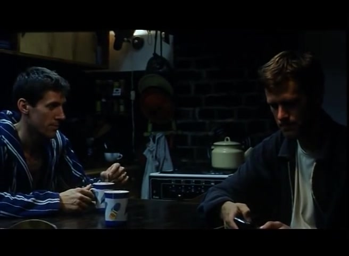

In [2]:
orig_vid[16]

## Test to see if matplotlib works well

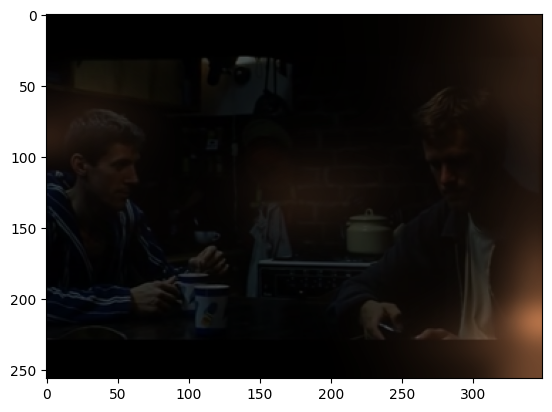

In [3]:
# im=misc.imread("photosAfterAverage/exampleAfterAverage1.jpg")
h, w = conv_features.shape[-2:]
plt.figure()
plt.imshow(orig_vid[16])

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.imshow(dec_attn_weights[0, 2].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.7, extent=(xmin, xmax, ymin, ymax))
# plt.imshow(cls_dec_attn_weights[0, 2, :].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.7, extent=(xmin, xmax, ymin, ymax))

# plt.imshow(test.detach().cpu().view(h, w), cmap='copper', interpolation='nearest', alpha=.8, extent=(xmin, xmax, ymin, ymax))
plt.show()

## load annotation files
#### TODO: load it with listfiles()

In [4]:
# frame_key is one of "xeGWXqSvC-8,0911", "CMCPhm2L400,1274", "Gvp-cj3bmIY,1725" 
query_logits = []
with open(detection) as f:
    for line in f.readlines():
        img_id = line.split(' ')[0]
        if key_frame != img_id:
            continue
        else:
            annotation = [float(n) for n in line.split('[')[1].split(']')[0].split(',')]
            # multi_hot_obj_label = [int(n) for n in annotation[6:]]
            query_logits.append(annotation)

anno_dict = {}
with open(gt) as f:
    for line in f.readlines():
        img_id = line.split(' ')[0]
        if img_id != key_frame:
            continue
        else:
            annotation = [int(float(n)) for n in line.split('[')[1].split(']')[0].split(',')]
            gt_coord = annotation[2:6]
            # gtxmin, gtymin, gtxmax, gtymax = gt_coord[0], gt_coord[1], gt_coord[2], gt_coord[3]
            gt_multi_hot_label = annotation[6:]
            gt_cat = [items[i+1] for i, e in enumerate(gt_multi_hot_label) if e]
            if img_id not in anno_dict.keys():
                anno_dict[img_id] = {
                    "obj": [gt_cat],
                    "coord": [gt_coord]
                }           
            else:
                anno_dict[img_id]["obj"].append(gt_cat)
                anno_dict[img_id]["coord"].append(gt_coord) 

### Visualization of decoder query attention (of the first transformer)

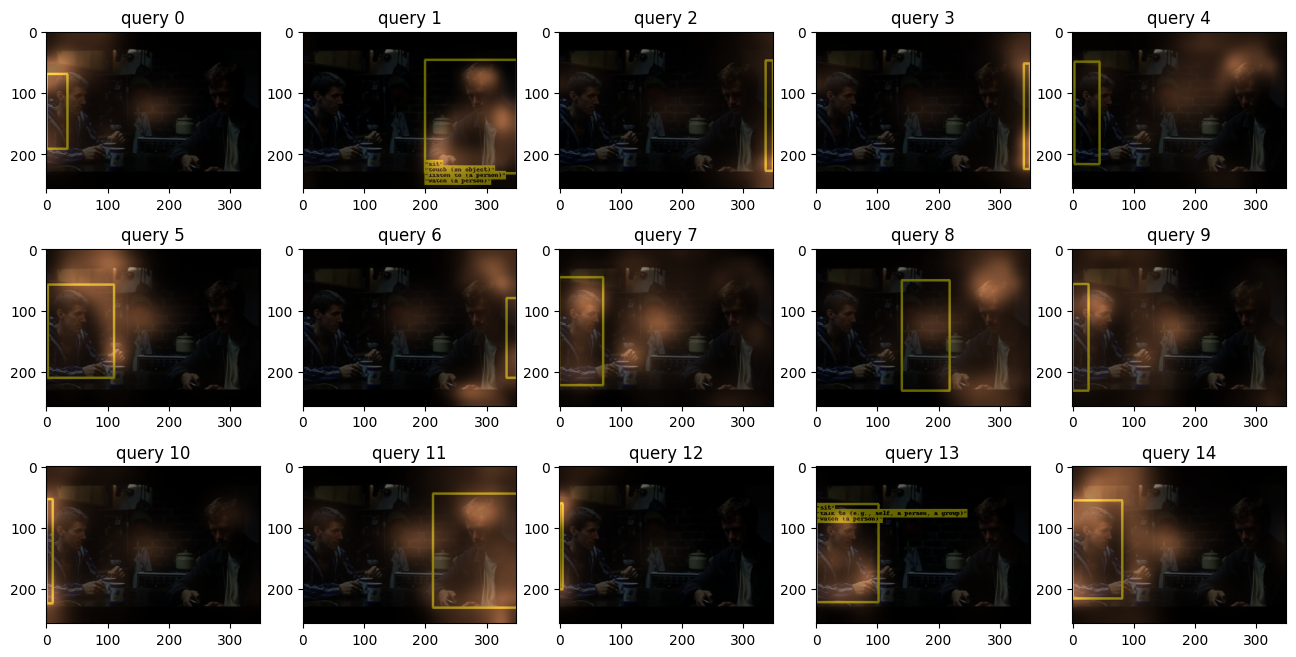

In [5]:
import copy
import visualization_utils_custom as vis_utils
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(h,w//3+1))
target_img = orig_vid[16]
for i, ax_i in enumerate(axs):
    for j in range(5):
        tgt_img = copy.deepcopy(target_img)
        coord = query_logits[i*5+j][:4]
        logits = query_logits[i*5+j][4:-1]
        bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]
        vis_utils.draw_bounding_box_on_image(
            tgt_img, bymin, bxmin, bymax, bxmax,
                color = 'Yellow',
                display_str_list=cat,
                use_normalized_coordinates=False,
                margin2=30
            )
        ax_i[j].imshow(tgt_img)
        ax_i[j].imshow(dec_attn_weights[0, i*5+j].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.6, extent=(xmin, xmax, ymin, ymax))
        ax_i[j].set_title("query {}".format(i*5+j))

### Visualization of decoder query attention (of the second transformer)
(fancy version)

In [ ]:
import copy
import visualization_utils_custom as vis_utils
import matplotlib.animation as animation
import matplotlib.image as mpimg
import imageio.v2 as imageio

# %matplotlib inline
# classification decoder weight plotting along time axis
cls_dec_attn_weights = cls_dec_attn_weights[0,:,:].view(1,15,4,h,w) # t=4 after all
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(h,w//3+1))
ims = []
def plot_along_(t):
    target_img = orig_vid[6*t+6]
    fig.suptitle("time {}".format(t))
    for i, ax_i in enumerate(axs):
        for j in range(5):
            tgt_img = copy.deepcopy(target_img)
            if t == 2:
                coord = query_logits[i*5+j][:4]
                logits = query_logits[i*5+j][4:-1]
                bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
                cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]
                vis_utils.draw_bounding_box_on_image(
                    tgt_img, bymin, bxmin, bymax, bxmax,
                        color = 'Yellow',
                        display_str_list=cat,
                        use_normalized_coordinates=False,
                        margin2=30
                    )
            ax_i[j].imshow(tgt_img)
            ax_i[j].imshow(cls_dec_attn_weights[0, i*5+j, t].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.5, extent=(xmin, xmax, ymin, ymax))
            ax_i[j].set_title("query {}".format(i*5+j))
    fig.savefig('./temp.png')
    img = imageio.imread('./temp.png')
    return img

for t in range(cls_dec_attn_weights.size(2)):
    ims.append(plot_along_(t))

imageio.mimsave('./temp.gif', ims, duration=1)

display.Image("./temp.gif")

# plt.show


### Visualization of decoder query attention (of the second transformer)
(Simpler version)

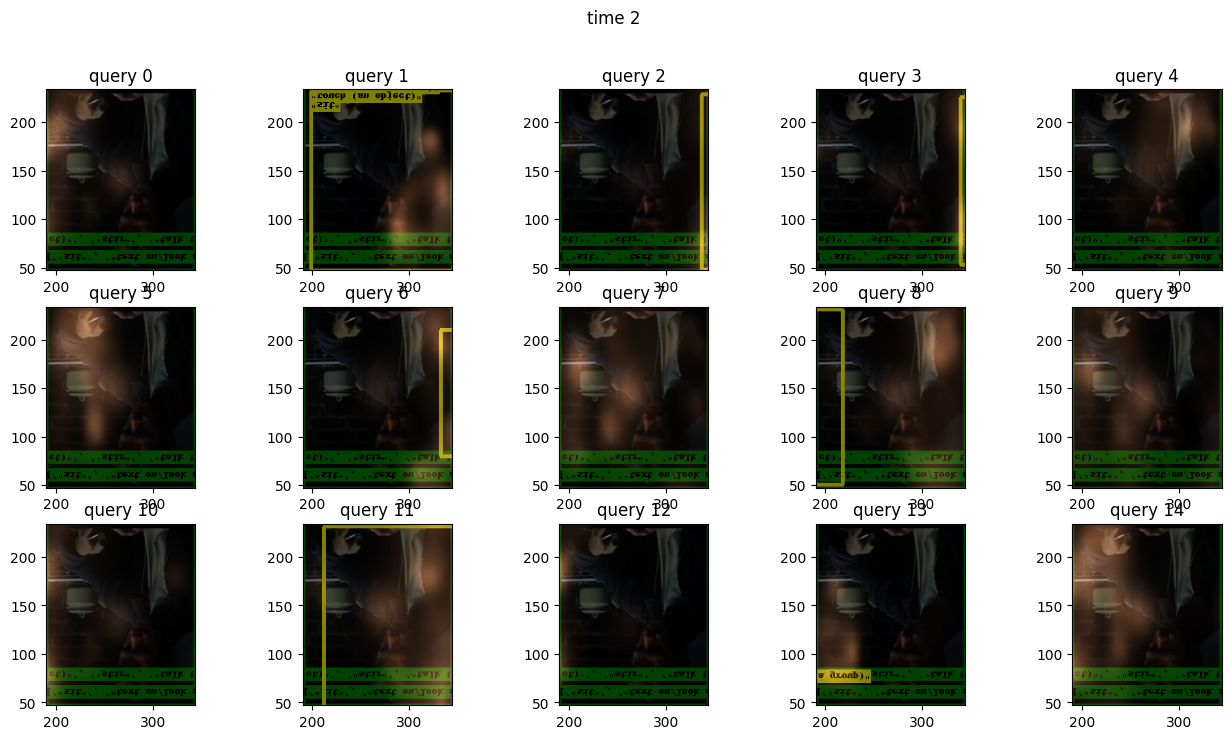

In [6]:
import copy
import visualization_utils_custom as vis_utils

%matplotlib inline
# classification decoder weight plotting along time axis
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(h,w//3+1))
ims = []
target_img = orig_vid[16]
t = 2
fig.suptitle("time {}".format(t))


for i, ax_i in enumerate(axs):
    for j in range(5):

        tgt_img = copy.deepcopy(target_img)
        for _, (obj, gt_coord) in enumerate(zip(anno_dict[key_frame]["obj"], anno_dict[key_frame]["coord"])):
            cat = str(obj)
            xmin, ymin, xmax, ymax = gt_coord[0], gt_coord[1], gt_coord[2], gt_coord[3]
            vis_utils.draw_bounding_box_on_image(
                tgt_img, ymin, xmin, ymax, xmax,
                color = 'Green',
                display_str_list=[cat],
                use_normalized_coordinates=False,
                margin2=20
            )

        coord = query_logits[i*5+j][:4]
        logits = query_logits[i*5+j][4:-1]
        bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]

        vis_utils.draw_bounding_box_on_image(
            tgt_img, bymin, bxmin, bymax, bxmax,
                color = 'Yellow',
                display_str_list=cat,
                use_normalized_coordinates=False,
                margin2=30
            )
        # ax_i[j].imshow(tgt_img)
        ax_i[j].imshow(dec_attn_weights[0, i*5+j].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.5, extent=(xmin, xmax, ymin, ymax))
        ax_i[j].set_title("query {}".format(i*5+j))

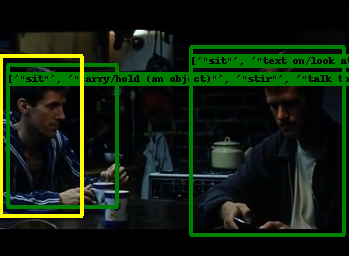

In [7]:
tgt_img

### Similarity visualization

In [ ]:
sim_mt1 = sim_matrix(enc_features, query_features) # bs, hw, nq
# sim_mt2 = sim_matrix(cls_enc_features, cls_query_features) # bs, hw, nq

sim_thres = 0.04
h, w = conv_features.shape[-2:]
sim_mt1 = sim_mt1.permute(0,2,1) # bs, query, h, w
# sim_mt2 = sim_mt2.permute(0,2,1)

import copy
import visualization_utils_custom as vis_utils
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(40,11))
target_img = orig_vid[16]
for i, ax_i in enumerate(axs):
    for j in range(5):
        tgt_img = copy.deepcopy(target_img)
        coord = query_logits[i*5+j][:4]
        logits = query_logits[i*5+j][4:-1]
        bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]
        vis_utils.draw_bounding_box_on_image(
            tgt_img, bymin, bxmin, bymax, bxmax,
                color = 'Yellow',
                display_str_list=cat,
                use_normalized_coordinates=False,
                margin2=30
            )
        ax_i[j].imshow(tgt_img)
        ax_i[j].imshow((sim_mt1[0, i*5+j].detach().cpu()>=sim_thres).view(h, w), cmap='copper', interpolation='None', alpha=.6, extent=(xmin, xmax, ymin, ymax))
        # ax_i[j].imshow((torch.ones_like(sim_mt1[0, i*5+j].detach().cpu())).view(h, w), cmap='copper', interpolation='None', alpha=.6, extent=(xmin, xmax, ymin, ymax))
        ax_i[j].set_title("query {}".format(i*5+j))

print(torch.min(sim_mt1), torch.max(sim_mt1))


In [ ]:
# sim_mt1 = sim_matrix(enc_features, query_features) # bs, hw, nq
# sim_mt2 = sim_matrix(cls_enc_features.mean(dim=1, keepdim=True), cls_query_features.mean(dim=1, keepdim=True)) # bs, hw, nq
sim_mt2 = sim_matrix(cls_enc_features[:, 0:1, :], cls_query_features[:, 0:1, :]) # bs, hw, nq

sim_thres = -0.05
h, w = conv_features.shape[-2:]
# sim_mt1 = sim_mt1.permute(0,2,1) >= sim_thres # bs, query, h, w
sim_mt2 = sim_mt2.permute(0,2,1)

import copy
import visualization_utils_custom as vis_utils
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(40,11))
target_img = orig_vid[16]
for i, ax_i in enumerate(axs):
    for j in range(5):
        tgt_img = copy.deepcopy(target_img)
        coord = query_logits[i*5+j][:4]
        logits = query_logits[i*5+j][4:-1]
        bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]
        vis_utils.draw_bounding_box_on_image(
            tgt_img, bymin, bxmin, bymax, bxmax,
                color = 'Yellow',
                display_str_list=cat,
                use_normalized_coordinates=False,
                margin2=30
            )
        ax_i[j].imshow(tgt_img)
        ax_i[j].imshow((sim_mt2[0, i*5+j].detach().cpu() >= sim_thres).view(h, w), cmap='copper', interpolation='None', alpha=.6, extent=(xmin, xmax, ymin, ymax))
        ax_i[j].set_title("query {}".format(i*5+j))

print(torch.min(sim_mt2), torch.max(sim_mt2))

### Stat for similarities

In [ ]:
inside = []
outside = []
mrg = 0.5
sim_thres = 0.05
for q in range(len(sim_mt1[0])): 
    q_inside = []
    q_outside = []
    coord = query_logits[q][:4]
    bxmin, bymin, bxmax, bymax = coord[0]/tgt_img.size[0], coord[1]/tgt_img.size[1], coord[2]/tgt_img.size[0], coord[3]/tgt_img.size[1]
    sims = sim_mt1[0, q].detach().cpu()
    for i, pixel in enumerate(sims):
        if ((i+0.5)//w >= bymin*h-mrg) and ((i+0.5)%w >= bxmin*w-mrg) and ((i+0.5)//w <= bymax*h+mrg) and ((i+0.5)%w <= bxmax*w+mrg):
            q_inside.append(pixel)
        else:
            q_outside.append(pixel)
    q_insim = sum([p > sim_thres for p in q_inside]) / len(q_inside) if len(q_inside) != 0 else 0
    q_outsim = sum([p > sim_thres for p in q_outside]) / len(q_outside) if len(q_outside) != 0 else 0
    inside.append(q_insim)
    outside.append(q_outsim)


inside_sim = np.mean(inside)
outside_sim = np.mean(outside)

print("inside_sim: ", inside_sim)
print("outside_sim: ", outside_sim)

In [ ]:
inside = []
outside = []
sim_thres = -0.05
for q in range(len(sim_mt2[0])): 
    coord = query_logits[q][:4]
    bxmin, bymin, bxmax, bymax = coord[0]/tgt_img.size[0], coord[1]/tgt_img.size[1], coord[2]/tgt_img.size[1], coord[3]/tgt_img.size[0]
    sims = sim_mt2[0, q].detach().cpu()
    for i, pixel in enumerate(sims):
        if ((i+0.5)//w >= bymin*h-mrg) and ((i+0.5)%w >= bxmin*w-mrg) and ((i+0.5)//w <= bymax*h+mrg) and ((i+0.5)%w <= bxmax*w+mrg):
            inside.append(pixel)
        else:
            outside.append(pixel)


inside_sim = sum([p > sim_thres for p in inside]) / len(inside) if len(inside) != 0 else 0
outside_sim = sum([p > sim_thres for p in outside]) / len(outside) if len(outside) != 0 else 0

print("cls inside_sim: ", inside_sim)
print("cls outside_sim: ", outside_sim)

In [ ]:
len(inside), len(outside)

In [ ]:
print(h,w)

In [ ]:
img_id

In [ ]:
gt_coord